In [230]:
import numpy as np
import pandas as pd
import re
import seaborn as sns
data = pd.read_csv("googleplaystore.csv")

def getinstalls(x):
    out = ""
    for i in re.findall(r".*[^+]", x)[0].split(","): out+=i
    print(out)
    print()
    return out

data = data.drop(["App", "Current Ver", "Last Updated", "Android Ver", "Price", "Content Rating", "Genres"], axis=1)
#data["Installs"] = data["Installs"].apply(getinstalls)
#data["Installs"] = pd.to_numeric(data["Installs"])

In [231]:
class Preprocessing():
    def __init__(self, data):
        self.data = data


    def getinstalls(self):
        data["Installs"] = data["Installs"].apply(lambda a: "".join(re.findall(r".*[^+]", a)[0].split(",")))
        data["Installs"] = pd.to_numeric(data["Installs"])
        data


preproc = Preprocessing(data)
preproc.getinstalls()
data


,Category,Rating,Reviews,Size,Installs,Type
0,ART_AND_DESIGN,4.1,159,19M,10000,Free
1,ART_AND_DESIGN,3.9,967,14M,500000,Free
2,ART_AND_DESIGN,4.7,87510,8.7M,5000000,Free
3,ART_AND_DESIGN,4.5,215644,25M,50000000,Free
4,ART_AND_DESIGN,4.3,967,2.8M,100000,Free
...,...,...,...,...,...,...
10835,FAMILY,4.5,38,53M,5000,Free
10836,FAMILY,5.0,4,3.6M,100,Free
10837,MEDICAL,NaN,3,9.5M,1000,Free
10838,BOOKS_AND_REFERENCE,4.5,114,Varies with device,1000,Free


In [232]:
def sizefunc(size):
    if 'M' in size:
        return(float(size[:-1])*1000)
    elif 'k' == size[-1:]:
        return(float(size[:-1]))
    else:
        return None

data["Size"] = data["Size"].map(sizefunc)
data.Size.fillna(method = 'ffill', inplace = True)
data["Size"]


0        19000.0
1        14000.0
2         8700.0
3        25000.0
4         2800.0
          ...   
10835    53000.0
10836     3600.0
10837     9500.0
10838     9500.0
10839    19000.0
Name: Size, Length: 10840, dtype: float64

In [233]:
data1 = data.copy()


In [234]:
def outlayers(data, field):
    distance = 1.5 * (np.percentile(data[field], 75) - np.percentile(data[field], 25))
    data.drop(data[data[field] > distance + np.percentile(data[field], 75)].index, inplace=True)
    data.drop(data[data[field] < np.percentile(data[field], 25) - distance].index, inplace=True)

/home/mischa/PycharmProjects/GooglePlay/venv/lib/python3.10/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='Size'>

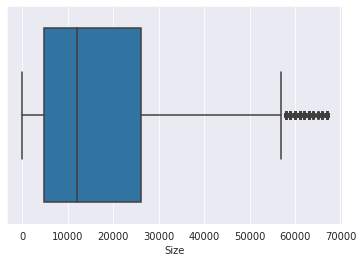

In [235]:
outlayers(data, "Size")
sns.boxplot(data.Size)


/home/mischa/PycharmProjects/GooglePlay/venv/lib/python3.10/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/mischa/PycharmProjects/GooglePlay/venv/lib/python3.10/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='Installs'>

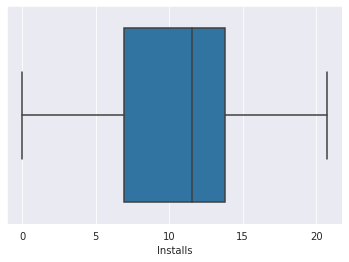

In [236]:
data.Installs = np.log(data.Installs)
outlayers(data, "Installs")
sns.boxplot(data.Installs)

In [237]:
data.loc[data.Installs <= 4, ["Installs"]] = data.Installs.median()

In [238]:
data.loc[data.Size > 50000, "Size"] = data.Size.median()

<AxesSubplot:>

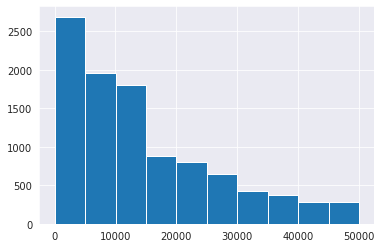

In [239]:
data.Size.hist()

/home/mischa/PycharmProjects/GooglePlay/venv/lib/python3.10/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='Size'>

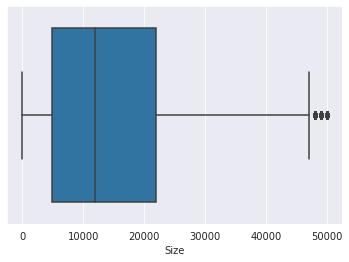

In [240]:
sns.boxplot(data.Size)

In [241]:
data.Reviews.info()

<class 'pandas.core.series.Series'>
Int64Index: 10164 entries, 0 to 10839
Series name: Reviews
Non-Null Count  Dtype
--------------  -----
10164 non-null  int64
dtypes: int64(1)
memory usage: 158.8 KB


/home/mischa/PycharmProjects/GooglePlay/venv/lib/python3.10/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='Reviews'>

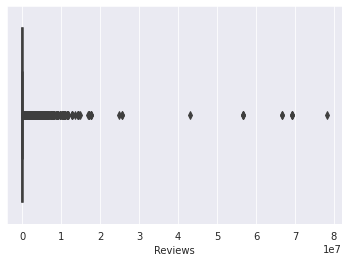

In [242]:
sns.boxplot(data.Reviews)

/home/mischa/PycharmProjects/GooglePlay/venv/lib/python3.10/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/mischa/PycharmProjects/GooglePlay/venv/lib/python3.10/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='Reviews'>

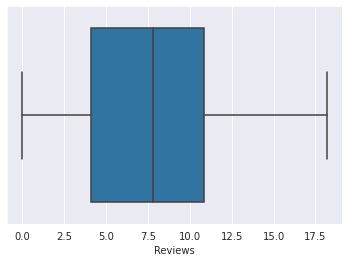

In [243]:
data.Reviews = np.log(data.Reviews)
outlayers(data, "Reviews")
sns.boxplot(data.Reviews)

dic = {"Free":0, "Paid":1}
data.Type = data.Type.replace(dic)
data.Type

In [244]:
def pricer(price):
    if price == "Free":
        return 0
    else:
        return 1
data["Type"] = data["Type"].map(pricer)

In [245]:
data["Type"]

0        0
1        0
2        0
3        0
4        0
        ..
10835    0
10836    0
10837    0
10838    0
10839    0
Name: Type, Length: 9589, dtype: int64

In [246]:
data.Category.value_counts()

FAMILY                 1692
GAME                    873
TOOLS                   794
PRODUCTIVITY            380
MEDICAL                 379
BUSINESS                377
COMMUNICATION           356
PERSONALIZATION         356
LIFESTYLE               341
FINANCE                 337
SPORTS                  335
PHOTOGRAPHY             327
HEALTH_AND_FITNESS      305
NEWS_AND_MAGAZINES      264
SOCIAL                  261
SHOPPING                253
TRAVEL_AND_LOCAL        229
DATING                  212
BOOKS_AND_REFERENCE     205
VIDEO_PLAYERS           167
EDUCATION               148
ENTERTAINMENT           144
MAPS_AND_NAVIGATION     130
FOOD_AND_DRINK          117
LIBRARIES_AND_DEMO       81
HOUSE_AND_HOME           80
AUTO_AND_VEHICLES        79
WEATHER                  79
ART_AND_DESIGN           64
COMICS                   60
EVENTS                   58
PARENTING                55
BEAUTY                   51
Name: Category, dtype: int64

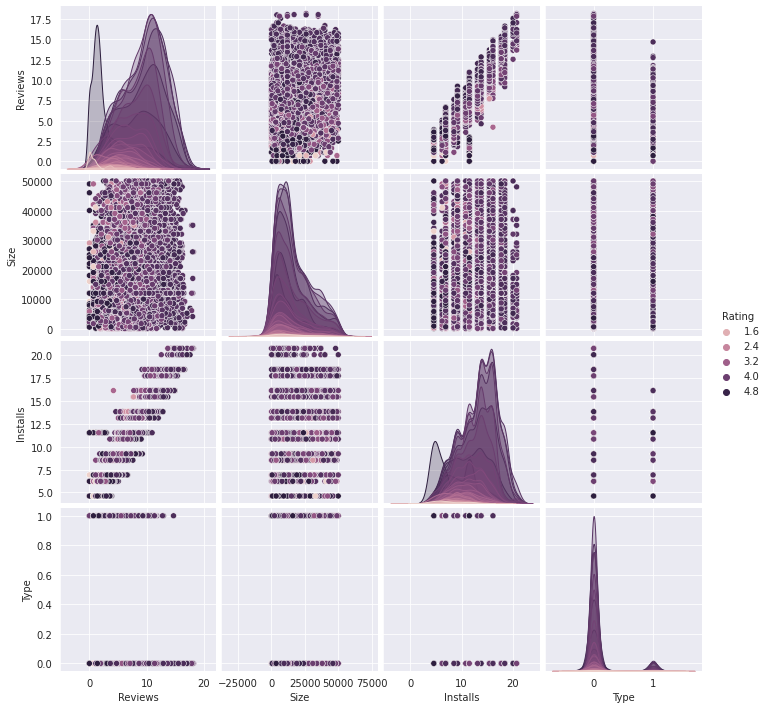

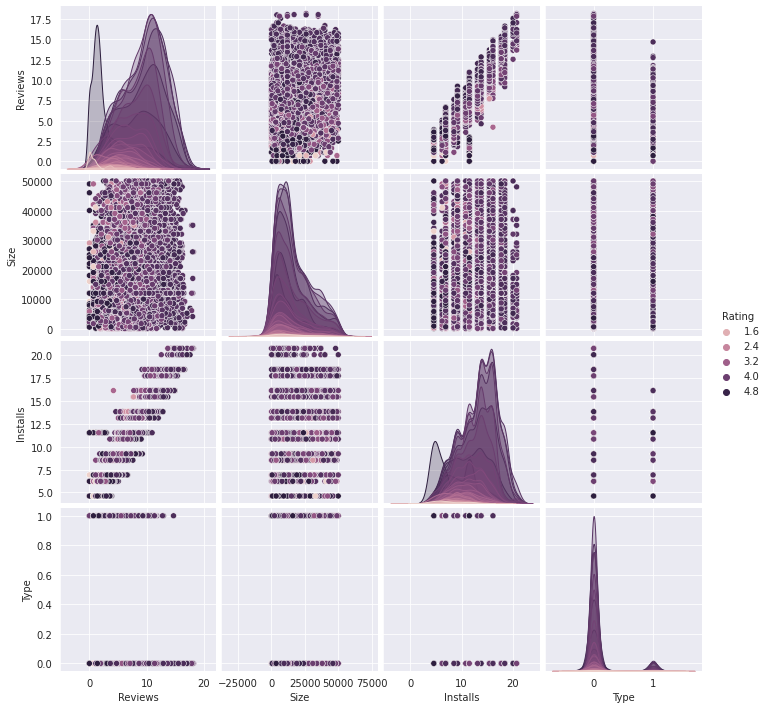

In [247]:
sns.pairplot(data, hue="Rating")

<AxesSubplot:>

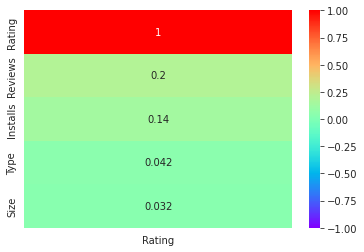

<AxesSubplot:>

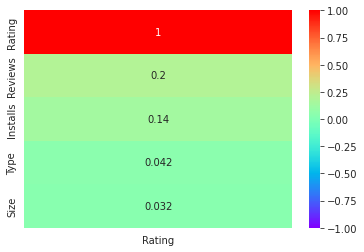

In [248]:
sns.heatmap(data.corr() [["Rating"]].sort_values(by="Rating", ascending=False), cmap="rainbow",vmin=-1, vmax=1, annot=True)

In [249]:
from sklearn.preprocessing import LabelEncoder, StandardScaler, RobustScaler

lbe = LabelEncoder()
data.Category = lbe.fit_transform(data.Category)
data.Category.head(100)

0     0
1     0
2     0
3     0
4     0
     ..
95    1
96    1
97    1
98    2
99    2
Name: Category, Length: 100, dtype: int64

0     0
1     0
2     0
3     0
4     0
     ..
95    1
96    1
97    1
98    2
99    2
Name: Category, Length: 100, dtype: int64

In [250]:
data.Category.value_counts()

11    1692
14     873
29     794
25     380
20     379
4      377
6      356
23     356
18     341
12     337
28     335
24     327
15     305
21     264
27     261
26     253
30     229
7      212
3      205
31     167
8      148
9      144
19     130
13     117
17      81
16      80
1       79
32      79
0       64
5       60
10      58
22      55
2       51
Name: Category, dtype: int64

11    1692
14     873
29     794
25     380
20     379
4      377
6      356
23     356
18     341
12     337
28     335
24     327
15     305
21     264
27     261
26     253
30     229
7      212
3      205
31     167
8      148
9      144
19     130
13     117
17      81
16      80
1       79
32      79
0       64
5       60
10      58
22      55
2       51
Name: Category, dtype: int64

In [251]:
data.Category = data.Category.astype("category")

In [252]:
data.Type = data.Type.astype("category")

In [253]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9589 entries, 0 to 10839
Data columns (total 6 columns):
 #   Column    Non-Null Count  Dtype   
---  ------    --------------  -----   
 0   Category  9589 non-null   category
 1   Rating    8726 non-null   float64 
 2   Reviews   9589 non-null   float64 
 3   Size      9589 non-null   float64 
 4   Installs  9589 non-null   float64 
 5   Type      9589 non-null   category
dtypes: category(2), float64(4)
memory usage: 652.8 KB
<class 'pandas.core.frame.DataFrame'>
Int64Index: 9589 entries, 0 to 10839
Data columns (total 6 columns):
 #   Column    Non-Null Count  Dtype   
---  ------    --------------  -----   
 0   Category  9589 non-null   category
 1   Rating    8726 non-null   float64 
 2   Reviews   9589 non-null   float64 
 3   Size      9589 non-null   float64 
 4   Installs  9589 non-null   float64 
 5   Type      9589 non-null   category
dtypes: category(2), float64(4)
memory usage: 652.8 KB


array([[<AxesSubplot:title={'center':'Rating'}>,
        <AxesSubplot:title={'center':'Reviews'}>],
       [<AxesSubplot:title={'center':'Size'}>,
        <AxesSubplot:title={'center':'Installs'}>]], dtype=object)

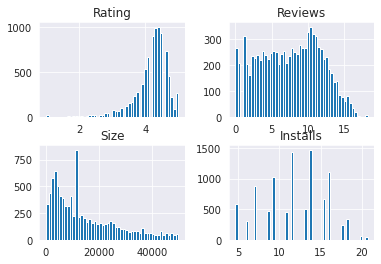

array([[<AxesSubplot:title={'center':'Rating'}>,
        <AxesSubplot:title={'center':'Reviews'}>],
       [<AxesSubplot:title={'center':'Size'}>,
        <AxesSubplot:title={'center':'Installs'}>]], dtype=object)

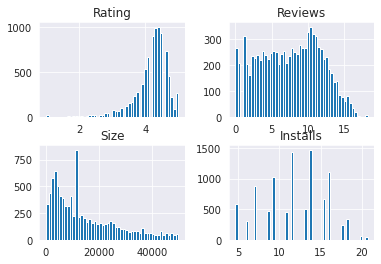

In [254]:
data.hist(bins=50)

In [255]:
sscaler = StandardScaler()
rscaler = RobustScaler()
data_scaled = pd.DataFrame(rscaler.fit_transform(data))

data_scaled.head()

,0,1,2,3,4,5
0,-1.071429,-0.4,-0.404299,0.409357,-0.370512,0.0
1,-1.071429,-0.8,-0.136179,0.116959,0.258977,0.0
2,-1.071429,0.8,0.532945,-0.192982,0.629488,0.0
3,-1.071429,0.4,0.666891,0.760234,1.000000,0.0
4,-1.071429,0.0,-0.136179,-0.538012,0.000000,0.0


,0,1,2,3,4,5
0,-1.071429,-0.4,-0.404299,0.409357,-0.370512,0.0
1,-1.071429,-0.8,-0.136179,0.116959,0.258977,0.0
2,-1.071429,0.8,0.532945,-0.192982,0.629488,0.0
3,-1.071429,0.4,0.666891,0.760234,1.000000,0.0
4,-1.071429,0.0,-0.136179,-0.538012,0.000000,0.0


array([[<AxesSubplot:title={'center':'0'}>,
        <AxesSubplot:title={'center':'1'}>],
       [<AxesSubplot:title={'center':'2'}>,
        <AxesSubplot:title={'center':'3'}>],
       [<AxesSubplot:title={'center':'4'}>,
        <AxesSubplot:title={'center':'5'}>]], dtype=object)

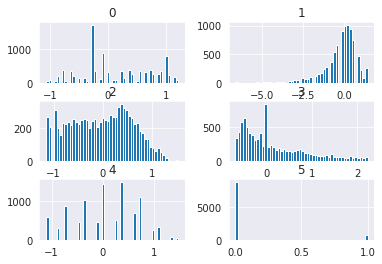

array([[<AxesSubplot:title={'center':'0'}>,
        <AxesSubplot:title={'center':'1'}>],
       [<AxesSubplot:title={'center':'2'}>,
        <AxesSubplot:title={'center':'3'}>],
       [<AxesSubplot:title={'center':'4'}>,
        <AxesSubplot:title={'center':'5'}>]], dtype=object)

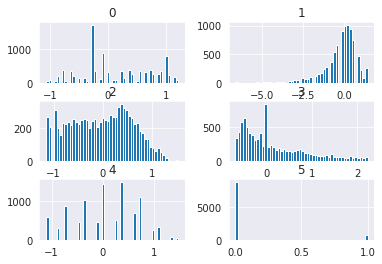

In [256]:
data_scaled.hist(bins=50)

In [257]:

from sklearn.model_selection import train_test_split
y = data.Rating
x = data.drop(["Rating"], axis=1)
y.head()

0    4.1
1    3.9
2    4.7
3    4.5
4    4.3
Name: Rating, dtype: float64

0    4.1
1    3.9
2    4.7
3    4.5
4    4.3
Name: Rating, dtype: float64

In [258]:
x.head()

,Category,Reviews,Size,Installs,Type
0,0,5.068904,19000.0,9.210340,0
1,0,6.874198,14000.0,13.122363,0
2,0,11.379508,8700.0,15.424948,0
3,0,12.281384,25000.0,17.727534,0
4,0,6.874198,2800.0,11.512925,0


,Category,Reviews,Size,Installs,Type
0,0,5.068904,19000.0,9.210340,0
1,0,6.874198,14000.0,13.122363,0
2,0,11.379508,8700.0,15.424948,0
3,0,12.281384,25000.0,17.727534,0
4,0,6.874198,2800.0,11.512925,0


In [259]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, shuffle=True, random_state=42)
x_train.head()

,Category,Reviews,Size,Installs,Type
8680,24,6.664409,18000.0,11.512925,0
4228,29,9.004177,3900.0,13.815511,0
4510,11,5.049856,43000.0,9.210340,0
9960,30,4.317488,19000.0,6.907755,0
10325,4,0.693147,8000.0,11.512925,0


,Category,Reviews,Size,Installs,Type
8680,24,6.664409,18000.0,11.512925,0
4228,29,9.004177,3900.0,13.815511,0
4510,11,5.049856,43000.0,9.210340,0
9960,30,4.317488,19000.0,6.907755,0
10325,4,0.693147,8000.0,11.512925,0
